## Bagging Classifiers and Uniqueness

$I$개 아이템을 가진 집합에서 $I$번 복원 추출 후 특정 아이템 $i$가 선택되지 않을 확률은 $(1 - I^{-1})^{I}$이다. 표본 크기가 커질수록 확률은 점근적으로 점근값 $\lim_{I \rightarrow \infty} (1-I^{-1})^I = e^{-1}$로 수렴한다. 이는 추출된 고유한 관측치 개수의 기대값이 $(1 - e^{-1}) \approx \frac{2}{3}$라는 뜻이 된다.

### 첫 번째 방법

부트스트랩을 실행하기 전에 중첩된 결과들을 삭제하는 것이다. 중첩이 완전한 것이 아니므로, 부분적 중첩이 있다고 해서 무조건 관측치를 삭제하면 많은 정보 손실이 발생한다.

### 두 번째 방법

두 번째 방법은 평균 고유도 $I^{-1} \sum_{i=1}^I \bar{u_i}$를 활용해 불필요한 정보를 가진 결과가 과도한 영향을 미치는 것을 감소시키는 것이다. 이에 따라 관측값의 일부인 `out['tW'].mean()`을 표본 추출하거나 작은 몇 배수 정도 표본 추출한다. `sklearn`의 `sklearn.ensemble.BaggingClassifier` class는 인수 `max_samples`를 받아들이는데 이 값은 `max_samples = out['tW'].mean()`으로 설정한다. 이러한 방법으로 in bag관측값이 고유도보다 훨씬 더 빈번하게 표본 추출되는 일이 없도록 한다. Random Forest의 경우 `max_samples`의 기능이 0.22버전으로 업데이트 되면서 생성되었다.

### 세 번째 방법 : Sequential Bootstrapping

세 번째이자 더 나은 해법은 순차적 복원추출법을 실행하는 것인데 중복을 통제하는 확률 변화에 따라 추출이 이뤄진다. Rao 등은 K개의 구분되는 원시 관측값이 나타날 때까지 복원을 동반한 순차적 표본추출법을 제안했다. 이는 흥미롭기는 하지만, 그들의 제안은 우리가 가진 금융 문제에는 적용하지 못한다. 이번 절에서는 중첩된 결과의 문제를 직접 해결하는 대체 방법을 소개한다.

첫째, 관측값 $X_i$는 uniform distribution $i \sim U(1,I)$에서 추출된다. 즉 특정값 $i$를 추출할 확률은 원래 $\delta_j^{(i)} = I^{-1}$이다. 두 번째 추출에 대해서 우리는 높은 중첩 결과를 가진 $X_j$가 추출될 확률을 낮추고자 한다. bootstrapping은 중복 추출이 허용되므로 $X_i$가 추출될 수 있다는 것을 기억하자. 그러나 $X_i$와 그 자신 사이에는 중첩이 있으므로 그 확률을 낮추고자 한다. 반복이 허용된 현재까지의 추출 시퀀스를 $\varphi$라고 하자. 현재까지는 $\varphi^{(1)} = \{i\}$라는 것을 알고 있다. 시각 $t$에서의 $j$의 고유도는 $u_{t,j}^{(2)} = 1_{t,j} \left( 1 + \sum_{k \in \varphi^{(1)}} 1_{t,k}\right)^{-1}$이다. 이는 기존에 추출된 시퀀스 $\varphi^{(1)}$에 다른 $J$들을 추가해 얻는 고유도의 결과이다. $j$의 고유도 평균은 $j$의 생애 주기 동안의 평균 $u_{t,j}^{(2)}$이다.

$$\bar{u}_{j}^{(2)} = \left( \sum_{t=1}^T u_{t,j}\right) \left( \sum_{t=1}^T 1_{t,j}\right)^{-1}$$

이제 갱신된 확률 $\{ \delta_{j}^{(2)} \}_{j=1, \dots, I}$에 기반을 둔 두 번째 추출을 할 수 있다

$$\delta_{j}^{(2)} = \bar{u}_{j}^{(2)} \left( \sum_{k=1}^I \bar{u}_k^{(2)} \right)^{-1}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from FinancialMachineLearning.labeling.labeling import *
from FinancialMachineLearning.features.volatility import daily_volatility

start_date = '2000-01-01'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    period = False,
    interval = '1d',
    multi_level_index = False,
    auto_adjust = True
)

[*********************100%***********************]  1 of 1 completed


In [2]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 20 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-24
2000-01-04   2000-01-24
2000-01-05   2000-01-25
2000-01-06   2000-01-26
2000-01-07   2000-01-27
Name: Date, dtype: datetime64[ns]

In [3]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 20 # moving average span
)

In [4]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.017084,2,1
2000-01-10,2000-01-12,0.026742,2,1
2000-01-11,2000-01-12,0.024329,2,1
2000-01-12,2000-01-13,0.032377,2,1
2000-01-13,2000-01-20,0.054135,2,1


In [5]:
#triple_barrier_events.to_parquet('triple_barrier_events.parquet')

#### Sequential Bootstrapping의 구현

아래의 코드는 두 인수로부터 지표 행렬(indicator matrix)을 도출하는데, 두 인수는 각각 바의 인덱스와 t1이며, chapter 3에서 출력된 것이다. 함수의 출력은 어떤 바가 각 관측값의 레이블에 영향을 미치는지를 알려주는 이진 행렬이다

In [6]:
from FinancialMachineLearning.sample_weights.bootstrapping import *

ind_mat = get_indicator_matrix(
    triple_barrier_events.index.to_series(),
    triple_barrier_events['t1']
)

아래의 코드는 각 특성 관측값의 고유도 평균을 반환한다. 입력은 위에서 출력된 지표 행렬이다

In [7]:
avg_uniqueness_ind = ind_mat_average_uniqueness(ind_mat)

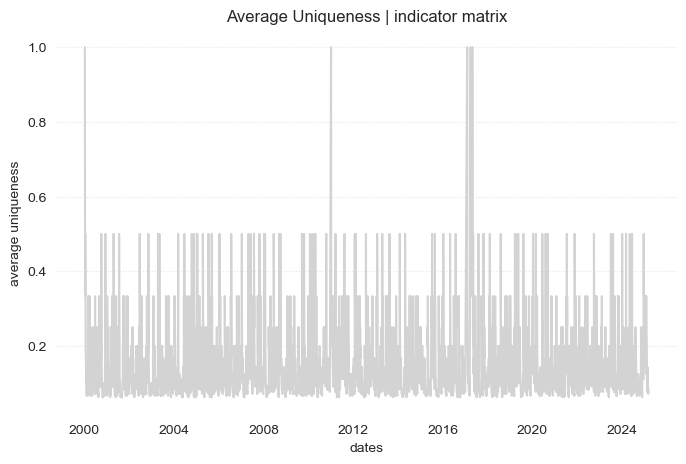

In [8]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(
    avg_uniqueness_ind,
    color = 'lightgray'
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('dates')
plt.ylabel('average uniqueness')
plt.title('Average Uniqueness | indicator matrix')
plt.show()

아래의 코드는 순차적 표본추출법에 의해 표본 추출된 특성의 인덱스를 출력한다. 입력은 지표행렬이자 최적의 표본 추출 길이 이며, 기본값은 지표행렬에 있는 행의 개수만큼 추출한 값이다

In [9]:
phi = seq_bootstrap(
    ind_mat.values,
    random_state = np.random.RandomState(42)
)

In [10]:
sequence_uniqueness = ind_mat_average_uniqueness(ind_mat[phi])

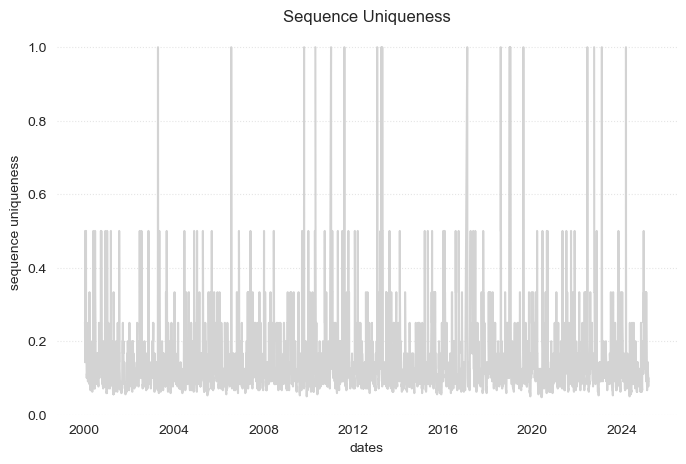

In [11]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(
    sequence_uniqueness,
    color = 'lightgray'
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('dates')
plt.ylabel('sequence uniqueness')
plt.title('Sequence Uniqueness')
plt.show()

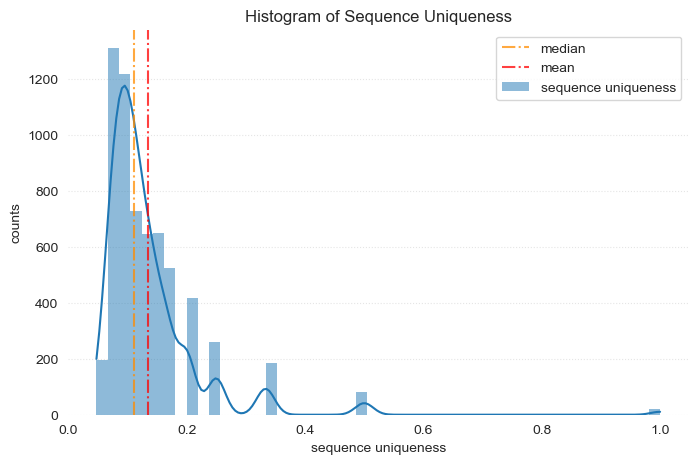

In [13]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(
    sequence_uniqueness, 
    bins = 50, 
    kde = True, 
    edgecolor = 'none',
    ax = ax,
    label = 'sequence uniqueness'
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(
    sequence_uniqueness.median(), 
    color = 'darkorange', 
    alpha = 0.75, 
    ls = '-.', 
    label = 'median'
)
plt.axvline(
    sequence_uniqueness.mean(), 
    color = 'red', 
    alpha = 0.75,
    ls = '-.', 
    label = 'mean'
)
plt.legend()
plt.xlabel('sequence uniqueness')
plt.ylabel('counts')
plt.title('Histogram of Sequence Uniqueness')
plt.show()